In [10]:
from sklearn import metrics
from sklearn.cluster import KMeans
from active_semi_clustering.semi_supervised.pairwise_constraints import COPKMeans, PCKMeans, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from textwrap import wrap
from sklearn import preprocessing
import os
import random
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

#Pre-process data set

def encode_columns(dataFrame, encode_cols):
    label_encoder = preprocessing.LabelEncoder()
    n_cols = len(dataFrame.columns)
    for col_cnt, col in enumerate(encode_cols):
        dataFrame.insert(n_cols + col_cnt, n_cols + col_cnt, label_encoder.fit_transform(dataFrame[col]))
    return dataFrame

#Load and pre-process data set
def preprocess_dataset(file_name, p_header, drop_cols, cols_with_unknown, cast_cols, encode_cols):
    #print(file_name)
    df = pd.read_csv(file_name, header = p_header)
    
    #Drop non-informative columns
    if(len(drop_cols) > 0):
        df = df.drop(drop_cols, axis=1)
    
    #Replace unknown values
    if(len(cols_with_unknown) > 0): 
        for col in cols_with_unknown:       
            df = replace_unkown_values(df, col)

    #Convert columns
    if(len(cast_cols) > 0):
        for col_type in cast_cols:
            if (col_type[1] == 'int64'):
                df[col_type[0]] = pd.to_numeric(df[col_type[0]])
    
    #Encode columns
    if(len(encode_cols) > 0):
        df = encode_columns(df, encode_cols)
    
    #print(df.head(10))
    #print(df.dtypes)
    npdata = df.to_numpy()
    return npdata

def replace_unkown_values(dataF, col_label):
    filter_unknown =  dataF[col_label].str.contains('?', case = False, regex=False)
    max_val =  dataF.loc[filter_unknown == False, col_label].max()
    max_val = int(max_val) + 1
    dataF.loc[(filter_unknown == True),col_label] = max_val
    return dataF

def preprocessing_dataset(dataFrame):
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column 0
    dataFrame[36]= label_encoder.fit_transform(dataFrame[0])
    #Converting string type to numeric type
    all_fields = np.arange(1, 36)
    int_fields = [12,36]
    field_to_convert = [x for x in all_fields if x not in int_fields]
    for field in field_to_convert:
        dataFrame = replace_unkown_values(dataFrame, field)
        dataFrame.iloc[: , field] = pd.to_numeric(dataFrame.iloc[:, field])
    
    dataFrame = dataFrame.drop([0], axis = 1)
    return dataFrame


# Draw scatterplots of instances
def plot_scatterplot(Data, Labels, axs, title, feat_plot, lbl_names, cls_names, symb_marker):
    unq_labels = np.unique(Labels)
    n_labels = len(unq_labels)
    max_item_lgn = 13
    col_lgn = 1
    if n_labels > max_item_lgn:
        col_lgn = 2

    colors = ['blue', 'red', 'green', 'yellow', 'black', 'maroon',   'lightgreen',
              'darkorange', 'darkkhaki', 'navy', 'darkseagreen', 'darkcyan', 
              'gold', 'deepskyblue', 'olive', 'slategrey', 'peru', 'royalblue', 'darkgoldenrod', 
              'indigo', 'tan', 'violet', 'sienna', 'purple', 'lightcoral', 'lightseagreen']

    for cls_cnt, cls in enumerate(unq_labels):
        axs.scatter(Data[Labels == cls, feat_plot[0]], Data[Labels == cls, feat_plot[1]], s=50,
                    label=cls_names[cls_cnt], color = colors[cls_cnt], marker = symb_marker)
    
    axs.set_title("\n".join(wrap(title, 40)))
    axs.grid(False)
    axs.legend(loc='best', ncol = col_lgn)
    axs.set_xlabel(lbl_names[feat_plot[0]])
    axs.set_ylabel(lbl_names[feat_plot[1]])
    
#Draw line-plots of metrics

def plot_NMI(Metrics, title, axs):  
    axs.plot(Metrics[:, 0], Metrics[:,1],'bs-')
    axs.plot(Metrics[:, 2], Metrics[:,3],'ro-')
    axs.plot(Metrics[:, 4], Metrics[:,5],'g^-')
    axs.plot(Metrics[:, 6], Metrics[:,7],'mx-')
    axs.set_title("\n".join(wrap(title, 40)))
    axs.grid('On')
    axs.legend(('COPK-means', 'PCK-means', 'MPCK-means', 'K-means'))
    axs.set_xlabel('Number of pairwise constraints')
    axs.set_ylabel('NMI')

def plot_ARS(Metrics, title, axs):  
    axs.plot(Metrics[:, 0], Metrics[:,1],'bs-')
    axs.plot(Metrics[:, 2], Metrics[:,3],'ro-')
    axs.plot(Metrics[:, 4], Metrics[:,5],'g^-')
    axs.plot(Metrics[:, 6], Metrics[:,7],'mx-')
    axs.set_title("\n".join(wrap(title, 40)))
    axs.grid('On')
    axs.legend(('COPK-means', 'PCK-means', 'MPCK-means', 'K-means'))
    axs.set_xlabel('Number of pairwise constraints')
    axs.set_ylabel('ARS')

def plot_ACC(Metrics, title, axs):  
    axs.plot(Metrics[:, 0], Metrics[:,1],'bs-')
    axs.plot(Metrics[:, 2], Metrics[:,3],'ro-')
    axs.plot(Metrics[:, 4], Metrics[:,5],'g^-')
    axs.plot(Metrics[:, 6], Metrics[:,7],'mx-')
    axs.set_title("\n".join(wrap(title, 40)))
    axs.grid('On')
    axs.legend(('COPK-means', 'PCK-means', 'MPCK-means', 'K-means'))
    axs.set_xlabel('Number of pairwise constraints')
    axs.set_ylabel('Accuracy')
    
def avg_values(all_metrics):
    constraints = np.unique(all_metrics[:, 0]) #Number of constraints
    n_algorithms = 4
    #print('metrics: ', all_metrics)
    result_values = np.empty((constraints.shape[0], n_algorithms))

    for i, constraint in enumerate(constraints):
        result_values[i,0] = np.mean(all_metrics[all_metrics[:, 0] == constraint,1])
        result_values[i,1] = np.mean(all_metrics[all_metrics[:, 2] == constraint,3])
        result_values[i,2] = np.mean(all_metrics[all_metrics[:, 4] == constraint,5])
        result_values[i,3] = np.mean(all_metrics[all_metrics[:, 6] == constraint,7])
        
    new_metrics = np.hstack((constraints.reshape((-1,1)), result_values[:,0].reshape((-1,1)), 
                             constraints.reshape((-1, 1)), result_values[:,1].reshape((-1,1)),
                             constraints.reshape((-1, 1)), result_values[:,2].reshape((-1,1)),
                             constraints.reshape((-1, 1)), result_values[:,3].reshape((-1,1))
                            ))
    return new_metrics  

def get_random_sample(p_Data, p_Labels, n_sample):
    n_rows, _ = p_Data.shape
    indexes = np.arange(n_rows)
    rand_sample = random.sample(indexes.tolist(), n_sample)
    unq = np.unique(rand_sample)
    return p_Data[rand_sample], p_Labels[rand_sample]

# Get constraints
def get_constraints(Data, Labels, Video_frames, n_constraints):
    ML = []
    CL = []
    ml_cnt = 0
    cl_cnt = 0
    n_elem = len(Labels) #Number of labels or frames
    Elements = Labels #Labels or video frames
    
    if(len(Video_frames) > 0):
        n_elem = len(Video_frames)
        Elements = Video_frames

    #print('n labels: ',  n_labels)
    i = 0
    j = 0
    while((i < n_elem) and ((len(ML) + len(CL)) < n_constraints)):
        while((j < n_elem) and ((len(ML) + len(CL)) < n_constraints)):
            if (i!=j):
                if (Elements[i] == Elements[j]):
                    ML.append((i,j))
                else:             
                    CL.append((i,j))
                
            j = j + 1
        j = 0
        i = i + 1
            
    #print('ml cnt: ', len(ML))
    #print('cl cnt: ', len(CL))
    #print('ML =', ML)
    #print('CL =', CL)
    return ML, CL

# Pairwise clustering using Resubstitution protocol
def pairwise_clustering(Data, Labels, Video_frames, arr_n_constraints):
    NMI_cls = []
    ARS_cls = []
    ACC_cls = []
    all_NMI = []
    all_ARS = []
    all_ACC = []
    
    n_unq_lbl = len(np.unique(Labels))
    cls_alg = [] # accumlate the algorithms
    cls_alg.append(COPKMeans(n_clusters=n_unq_lbl, max_iter=30))
    cls_alg.append(PCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(MPCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(KMeans(n_clusters=n_unq_lbl, random_state=5))

    n_cls = len(cls_alg)
    
    for n_const, const in enumerate(arr_n_constraints):     
        ML, CL = get_constraints(Data, Labels, Video_frames, const)
        NMI_cls = []
        ARS_cls = []
        ACC_cls = []
        for clus_cnt, clusterer in enumerate(cls_alg):
            #print('clus cnt: ', clus_cnt)
            if(clus_cnt < n_cls-1):
                clusterer.fit(Data, ml=ML, cl=CL) 
            else:
                clusterer.fit(Data)
                
            ARS = metrics.adjusted_rand_score(Labels, clusterer.labels_)
            NMI = normalized_mutual_info_score(Labels, clusterer.labels_)
            accuracy = np.mean(Labels == clusterer.labels_)

            if len(NMI_cls) == 0:
                NMI_cls = (const, round(NMI, 4))
                ARS_cls = (const, round(ARS, 4))
                ACC_cls = (const, round(accuracy, 4))
            else:
                NMI_cls = np.hstack((NMI_cls, (const, round(NMI, 4))))
                ARS_cls = np.hstack((ARS_cls, (const, round(ARS, 4))))
                ACC_cls = np.hstack((ACC_cls, (const, round(accuracy, 4))))

        all_NMI.append(NMI_cls)
        all_ARS.append(ARS_cls)
        all_ACC.append(ACC_cls)
  
    all_NMI = np.array(all_NMI)
    all_ARS = np.array(all_ARS)
    all_ACC = np.array(all_ACC)
    #print('NMI: ', all_NMI)  
    #print('METRICS: ', all_ARS)
    #all_NMI = avg_values(all_NMI)
    #all_ARS = avg_values(all_ARS)
    
    return all_NMI, all_ARS, all_ACC

#Perform clustering

def perform_clustering(params):
    
    NMI_cls = []
    ARS_cls = []
    ACC_cls = []
    
    clusterer = params[0]
    Data = params[1][0]
    Labels = params[1][1]
    ML = params[1][2]
    CL = params[1][3]
    test_index = params[1][4]
    const = params[1][5]
    
    print('Arrives here!')
    print('clusterer: ', clusterer)
    print('Data: ', Data)
    print('Labels: ' , Labels)
    print('ML: ', ML)
    print('CL: ', CL)
    print('test_index: ', test_index)
    print('const: ', const)
    
    '''
    Tst_data = Data[test_index]
    Tst_labels = Labels[test_index]
    
    if(clus_cnt < n_cls-1):
        clusterer.fit(Data, ml=ML, cl=CL) 
    else:
        clusterer.fit(Data)

    ARS = metrics.adjusted_rand_score(Tst_labels, clusterer.labels_[test_index])
    NMI = normalized_mutual_info_score(Tst_labels, clusterer.labels_[test_index])
    accuracy = np.mean(Tst_labels == clusterer.labels_[test_index])

    if len(NMI_cls) == 0:
        NMI_cls = (const, round(NMI, 4))
        ARS_cls = (const, round(ARS, 4))
        ACC_cls = (const, round(accuracy, 4))
    else:
        NMI_cls = np.hstack((NMI_cls, (const, round(NMI, 4))))
        ARS_cls = np.hstack((ARS_cls, (const, round(ARS, 4))))
        ACC_cls = np.hstack((ACC_cls, (const, round(accuracy, 4))))

    '''

    return NMI_cls, ARS_cls, ACC_cls

def test_clustering_k_fold(params):
    print('Arrives here!')
    
        
    NMI_cls = []
    ARS_cls = []
    ACC_cls = []
    all_NMI = []
    all_ARS = []
    all_ACC = []
    
    '''
    Data = params[0][0]
    Labels = params[0][1]
    Video_frames = params[0][2]
    arr_n_constraints = params[0][3]
    k_folds = params[0][4]
    

    print('Data: ', Data)
    print('Labels: ' , Labels)
    print('k_folds: ', k_folds)
    

    
    
    n_unq_lbl = len(np.unique(Labels))
    cls_alg = [] # accumlate the algorithms
    cls_alg.append(COPKMeans(n_clusters=n_unq_lbl, max_iter=30))
    cls_alg.append(PCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(MPCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(KMeans(n_clusters=n_unq_lbl, random_state=5))

    n_cls = len(cls_alg)
    
    kf = KFold(n_splits=k_folds)
    split_data = kf.split(Data)
    
    for train_index, test_index in split_data:
        Trn_data = Data[train_index]
        Trn_labels = Labels[train_index]
        Tst_data = Data[test_index]
        Tst_labels = Labels[test_index]
    
        for n_const, const in enumerate(arr_n_constraints):         
            ML, CL = get_constraints(Trn_data, Trn_labels, Video_frames, const)
        
            NMI_cls = []
            ARS_cls = []
            ACC_cls = []
            
            for clus_cnt, clusterer in enumerate(cls_alg):
                #print('clus cnt: ', clus_cnt)
                if(clus_cnt < n_cls-1):
                    clusterer.fit(Data, ml=ML, cl=CL) 
                else:
                    clusterer.fit(Data)

                ARS = metrics.adjusted_rand_score(Tst_labels, clusterer.labels_[test_index])
                NMI = normalized_mutual_info_score(Tst_labels, clusterer.labels_[test_index])
                accuracy = np.mean(Tst_labels == clusterer.labels_[test_index])

                if len(NMI_cls) == 0:
                    NMI_cls = (const, round(NMI, 4))
                    ARS_cls = (const, round(ARS, 4))
                    ACC_cls = (const, round(accuracy, 4))
                else:
                    NMI_cls = np.hstack((NMI_cls, (const, round(NMI, 4))))
                    ARS_cls = np.hstack((ARS_cls, (const, round(ARS, 4))))
                    ACC_cls = np.hstack((ACC_cls, (const, round(accuracy, 4))))
            
            
            all_NMI.append(NMI_cls)
            all_ARS.append(ARS_cls)
            all_ACC.append(ACC_cls)
  
    all_NMI = np.array(all_NMI)
    all_ARS = np.array(all_ARS)
    all_ACC = np.array(all_ACC)
    #print('NMI: ', all_NMI)  
    #print('METRICS: ', all_ARS)
    all_NMI = avg_values(all_NMI)
    all_ARS = avg_values(all_ARS)
    all_ACC = avg_values(all_ACC)
    '''
    
    return all_NMI, all_ARS, all_ACC

# Pairwise clustering using 10-fold cross validation protocol
def pairwise_clustering_k_fold(Data, Labels, Video_frames, arr_n_constraints, k_folds):
    NMI_cls = []
    ARS_cls = []
    ACC_cls = []
    all_NMI = []
    all_ARS = []
    all_ACC = []
    
    n_unq_lbl = len(np.unique(Labels))
    cls_alg = [] # accumlate the algorithms
    cls_alg.append(COPKMeans(n_clusters=n_unq_lbl, max_iter=30))
    cls_alg.append(PCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(MPCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(KMeans(n_clusters=n_unq_lbl, random_state=5))

    n_cls = len(cls_alg)
    
    kf = KFold(n_splits=k_folds)
    split_data = kf.split(Data)
    
    for train_index, test_index in split_data:
        Trn_data = Data[train_index]
        Trn_labels = Labels[train_index]
        Tst_data = Data[test_index]
        Tst_labels = Labels[test_index]
    
        for n_const, const in enumerate(arr_n_constraints):         
            ML, CL = get_constraints(Trn_data, Trn_labels, Video_frames, const)
            
            '''
            params = [ [cls_alg[0],[Data, Labels, ML, CL, test_index, const]],
                       [cls_alg[1],[Data, Labels, ML, CL, test_index, const]],
                       [cls_alg[2],[Data, Labels, ML, CL, test_index, const]],
                       [cls_alg[3],[Data, Labels, ML, CL, test_index, const]]]
            '''
            #print('Paramas: ')
            #print(params)
            
            #start_time = time.perf_counter()
            #elem = params[0]

            #result = Parallel(n_jobs=3)(delayed(perform_clustering)(i) for i in params)
            #finish_time = time.perf_counter()
            #print(f"Program finished in {finish_time-start_time} seconds!!")
            
        
            NMI_cls = []
            ARS_cls = []
            ACC_cls = []
            
            for clus_cnt, clusterer in enumerate(cls_alg):
                #print('clus cnt: ', clus_cnt)
                if(clus_cnt < n_cls-1):
                    clusterer.fit(Data, ml=ML, cl=CL) 
                else:
                    clusterer.fit(Data)

                ARS = metrics.adjusted_rand_score(Tst_labels, clusterer.labels_[test_index])
                NMI = normalized_mutual_info_score(Tst_labels, clusterer.labels_[test_index])
                accuracy = np.mean(Tst_labels == clusterer.labels_[test_index])

                if len(NMI_cls) == 0:
                    NMI_cls = (const, round(NMI, 4))
                    ARS_cls = (const, round(ARS, 4))
                    ACC_cls = (const, round(accuracy, 4))
                else:
                    NMI_cls = np.hstack((NMI_cls, (const, round(NMI, 4))))
                    ARS_cls = np.hstack((ARS_cls, (const, round(ARS, 4))))
                    ACC_cls = np.hstack((ACC_cls, (const, round(accuracy, 4))))
            
            
            all_NMI.append(NMI_cls)
            all_ARS.append(ARS_cls)
            all_ACC.append(ACC_cls)
  
    all_NMI = np.array(all_NMI)
    all_ARS = np.array(all_ARS)
    all_ACC = np.array(all_ACC)
    #print('NMI: ', all_NMI)  
    #print('METRICS: ', all_ARS)
    all_NMI = avg_values(all_NMI)
    all_ARS = avg_values(all_ARS)
    all_ACC = avg_values(all_ACC)
        
    return all_NMI, all_ARS, all_ACC



In [3]:
import time
from joblib import Parallel, delayed
 
'''
def cube(x):
    return x**3
 
start_time = time.perf_counter()
result = Parallel(n_jobs=3)(delayed(cube)(i) for i in range(1,1000))
finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")
print(result[0:10])
'''

def other_cube(x):
    return (x[0]*x[1])**3

X = [[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],[8,8],[9,9],[10,10],[11,11],[12,12],[13,13],[14,14],[15,15]]
start_time = time.perf_counter()
result = Parallel(n_jobs=3)(delayed(other_cube)(i) for i in X)
finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds!!")
print(result)


Program finished in 0.014233195019187406 seconds!!
[1, 64, 729, 4096, 15625, 46656, 117649, 262144, 531441, 1000000, 1771561, 2985984, 4826809, 7529536, 11390625]


Iris Data Set
Wine Data Set
Diabetes Data Set
Time for pairwise clustering :131.0859  seconds
Breast cancer Data Set
Time for pairwise clustering :113.3096  seconds
Pen-digits Data Set
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :7030.1581  seconds
Letter-recognition Data Set
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :10908.6393  seconds


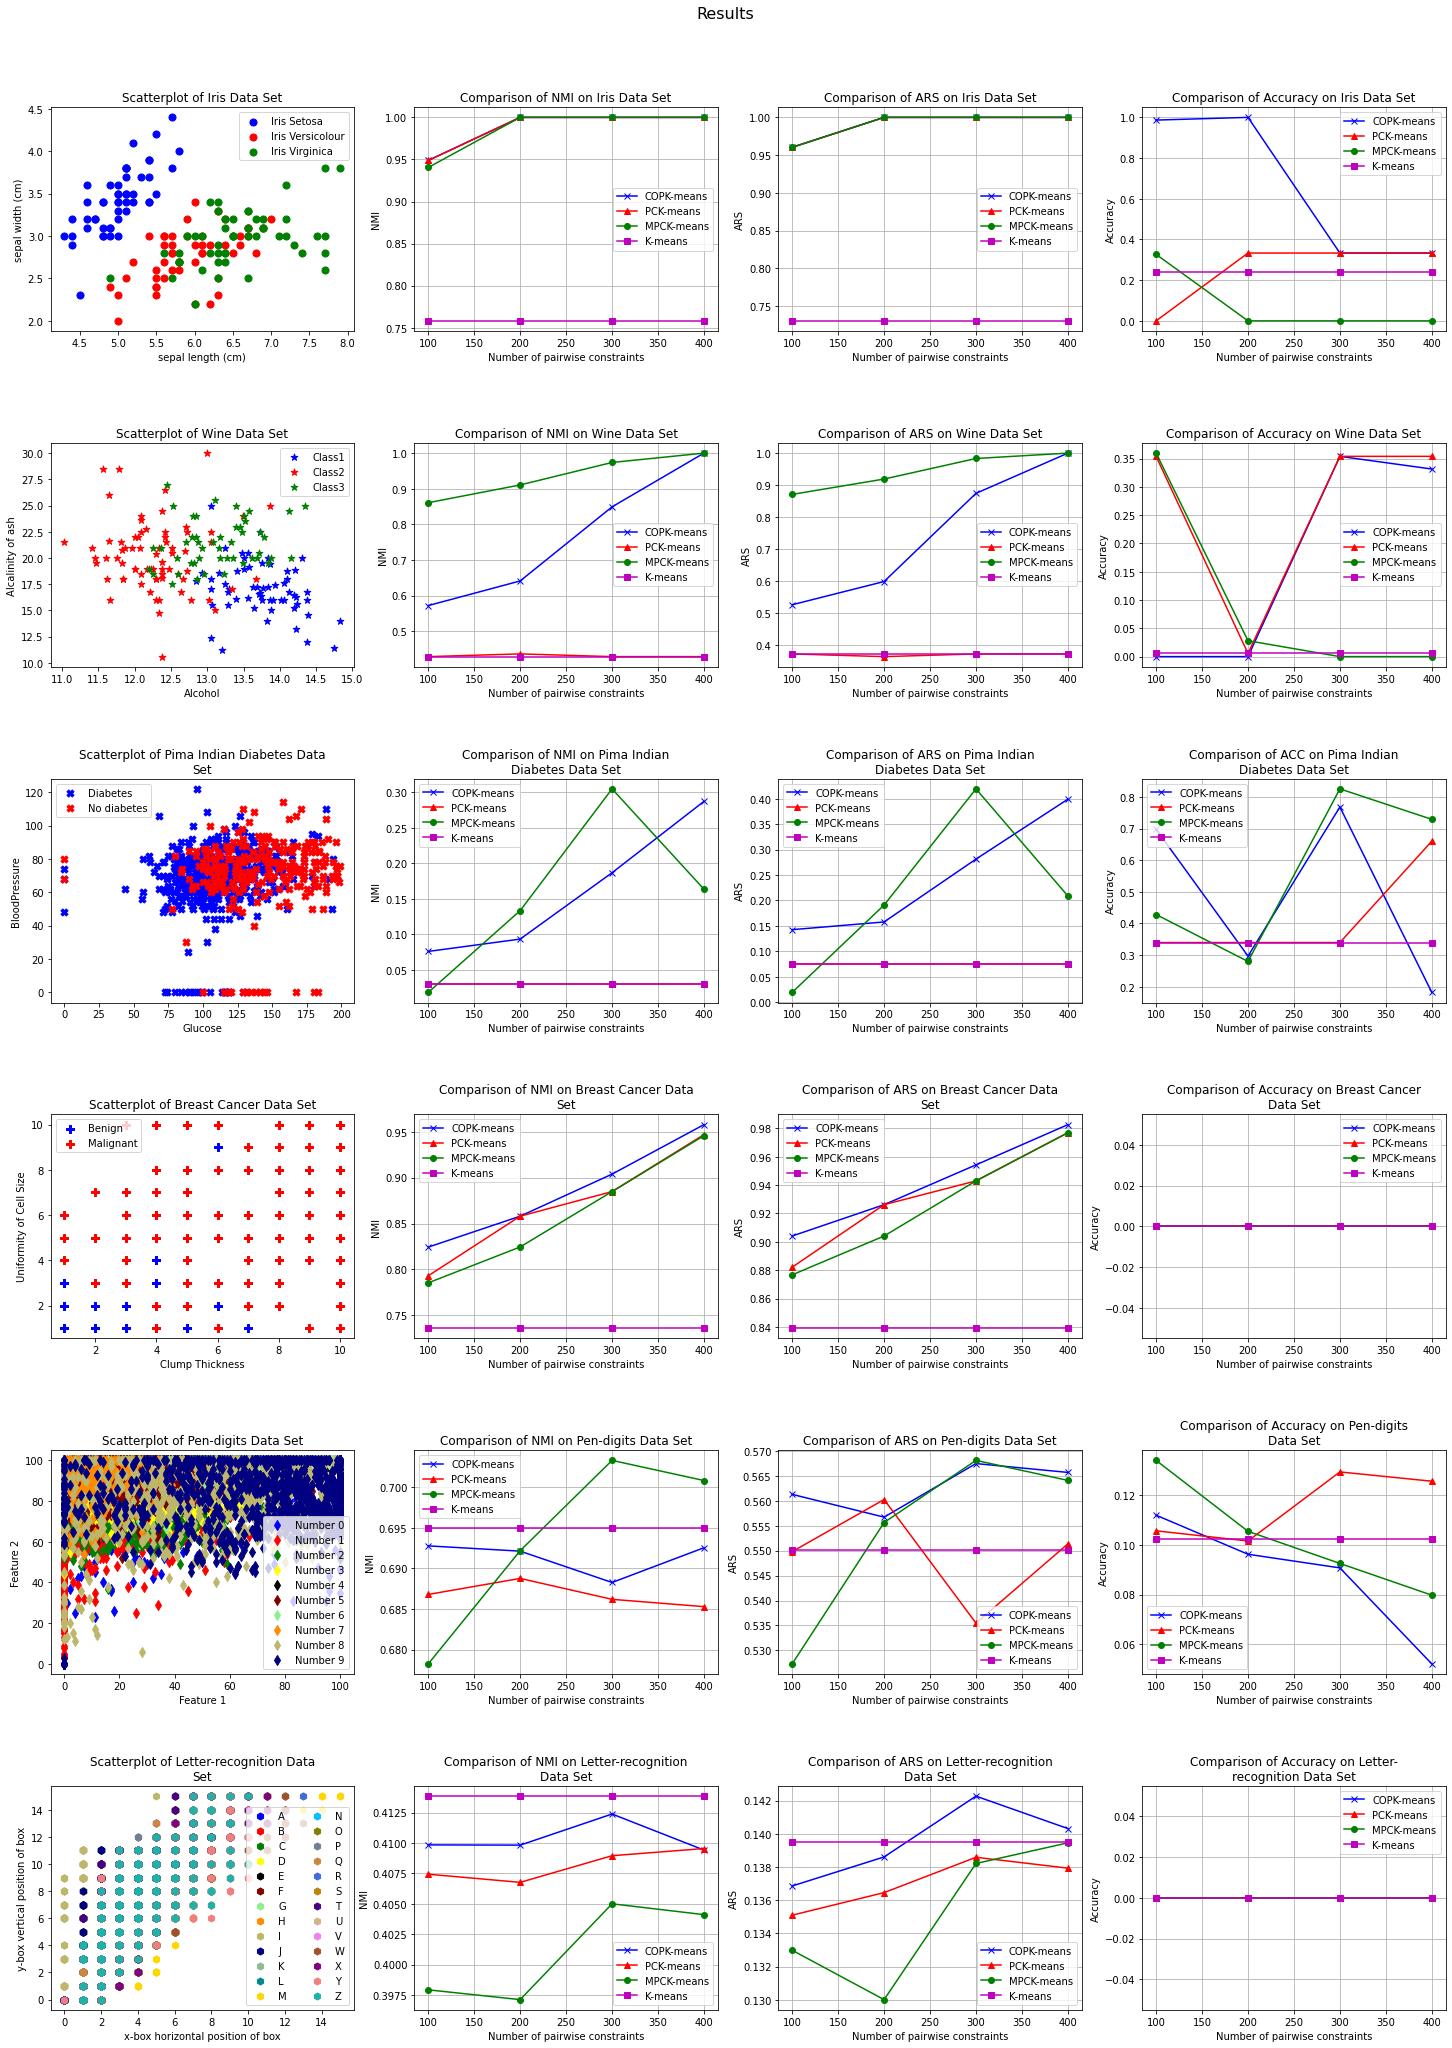

In [7]:
from time import time
import matplotlib.pyplot as plt
import os
from sklearn import datasets

figure, axs = plt.subplots(6, 4, figsize = (25,35))
plt.subplots_adjust(hspace = 0.5) 
plt.suptitle('Results', fontsize=16, y=0.92)
folder = 'DataSets'
#Reading Iris Dataset
titles = ['Comparison of NMI on Iris Data Set', 'Comparison of ARS on Iris Data Set', 
          'Comparison of Accuracy on Iris Data Set']
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
lbl_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
cls_names = ['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']
symb_marker = 'o'
n_sample = 150 #Total number of instances
print('Iris Data Set')
Data, Labels = datasets.load_iris(return_X_y=True)
Data, Labels = get_random_sample(Data, Labels, n_sample) #Order randomly the dataset
plot_scatterplot(Data, Labels, axs[0,0], 'Scatterplot of Iris Data Set', 
                 [0,1], lbl_names, cls_names, symb_marker)

all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, arr_n_constraints)
plot_NMI(all_NMI, titles[0], axs[0,1])
plot_ARS(all_ARS, titles[1], axs[0,2])
plot_ACC(all_ACC, titles[2], axs[0,3])

#Reading wine Dataset

print('Wine Data Set')
src = os.path.join(folder, 'wine.data')
npdata = preprocess_dataset(src, None, [], [], [], [])
Data = npdata[:, 1:]
Labels = npdata[:,0] 
n_sample = 178 #Total number of instances
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
feat_plot = [0,3]
lbl_names = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 
            'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
            'OD280/OD315 of diluted wines', 'Proline']
cls_names = ['Class1', 'Class2', 'Class3']
titles = ['Comparison of NMI on Wine Data Set', 'Comparison of ARS on Wine Data Set', 
          'Comparison of Accuracy on Wine Data Set']
Data, Labels = get_random_sample(Data, Labels, n_sample) #Order randomly the dataset
symb_marker = '*'
plot_scatterplot(Data, Labels, axs[1,0], 'Scatterplot of Wine Data Set', 
                 feat_plot, lbl_names, cls_names, symb_marker)

all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, arr_n_constraints)
plot_NMI(all_NMI, titles[0], axs[1,1])
plot_ARS(all_ARS, titles[1], axs[1,2])
plot_ACC(all_ACC, titles[2], axs[1,3])

#Reading Diabetes Dataset
print('Diabetes Data Set')

s_time_clus = time()
src = os.path.join(folder, 'diabetes.csv')
npdata = preprocess_dataset(src, 0, [], [], [], [])
Data = npdata[:, :-1]
Labels = npdata[:,-1] 
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
titles = ['Comparison of NMI on Pima Indian Diabetes Data Set', 
          'Comparison of ARS on Pima Indian Diabetes Data Set', 
          'Comparison of ACC on Pima Indian Diabetes Data Set']
feat_plot = [1,2] #Features to plot
lbl_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
cls_names = ['Diabetes', 'No diabetes']
symb_marker = 'X'
plot_scatterplot(Data, Labels, axs[2,0], 'Scatterplot of Pima Indian Diabetes Data Set', 
                 feat_plot, lbl_names, cls_names, symb_marker)

all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, arr_n_constraints)
plot_NMI(all_NMI, titles[0], axs[2,1])
plot_ARS(all_ARS, titles[1], axs[2,2])
plot_ACC(all_ACC, titles[2], axs[2,3])

e_time_clus = time()
print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

#Reading breast cancer data set

print('Breast cancer Data Set')
s_time_clus = time()
src = os.path.join(folder, 'breast-cancer-wisconsin.data')
npdata = preprocess_dataset(src, None, [0], [6], [(6, 'int64')], [])
Data = npdata[:, :-1]
Labels = npdata[:,-1] 
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
titles = ['Comparison of NMI on Breast Cancer Data Set', 'Comparison of ARS on Breast Cancer Data Set', 
          'Comparison of Accuracy on Breast Cancer Data Set']
feat_plot = [0,1] #Features to plot
lbl_names = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion',
            'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
cls_names = ['Benign', 'Malignant']
symb_marker = 'P'

plot_scatterplot(Data, Labels, axs[3,0], 'Scatterplot of Breast Cancer Data Set', 
                 feat_plot, lbl_names, cls_names, symb_marker)

all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, arr_n_constraints)
plot_NMI(all_NMI, titles[0], axs[3,1])
plot_ARS(all_ARS, titles[1], axs[3,2])
plot_ACC(all_ACC, titles[2], axs[3,3])

e_time_clus = time()
print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

#Reading Pen-digits Dataset

print('Pen-digits Data Set')
src = os.path.join(folder, 'pendigits.tra')

npdata_trn = preprocess_dataset(src, None, [], [], [], [])
Data_Trn = npdata_trn[:, :-1] 
Labels_Trn = npdata_trn[:,-1] 

src = os.path.join(folder, 'pendigits.tes')
npdata_tst = preprocess_dataset(src, None, [], [], [], [])
Data_Tst = npdata_tst[:, :-1] 
Labels_Tst = npdata_tst[:,-1] 

Data = np.vstack((Data_Trn, Data_Tst))
Labels = np.vstack((Labels_Trn.reshape((-1,1)), Labels_Tst.reshape(-1,1)))
Labels = Labels.flatten()
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints

titles = ['Comparison of NMI on Pen-digits Data Set', 'Comparison of ARS on Pen-digits Data Set', 
          'Comparison of Accuracy on Pen-digits Data Set']
n_runs = 20
n_sample = 1000
s_time_clus = time()

feat_plot = [0,1] #Features to plot
lbl_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7',
            'Feature 8', 'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 'Feature 13', 'Feature 14',
            'Feature 15', 'Feature 16']
cls_names = ['Number 0', 'Number 1', 'Number 2', 'Number 3', 'Number 4', 'Number 5', 'Number 6', 
             'Number 7', 'Number 8', 'Number 9']
symb_marker = 'd' # Marker

plot_scatterplot(Data, Labels, axs[4,0], 'Scatterplot of Pen-digits Data Set', 
                 feat_plot, lbl_names, cls_names, symb_marker)

all_NMI = []
all_ARS = []
all_ACC = []

for i in range(n_runs): 
    print('Run # ', i)
    spl_Data, spl_Labels = get_random_sample(Data, Labels, n_sample)
    sample_NMI, sample_ARS, sample_ACC = pairwise_clustering(spl_Data, spl_Labels, arr_n_constraints)
    all_NMI.extend(sample_NMI)
    all_ARS.extend(sample_ARS)
    all_ACC.extend(sample_ACC)

all_NMI = np.array(all_NMI)
all_ARS = np.array(all_ARS)
all_ACC = np.array(all_ACC)

all_NMI = avg_values(all_NMI)
all_ARS = avg_values(all_ARS)
all_ACC = avg_values(all_ACC)

plot_NMI(all_NMI, titles[0], axs[4,1])
plot_ARS(all_ARS, titles[1], axs[4,2])
plot_ACC(all_ACC, titles[2], axs[4,3])

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

print('Letter-recognition Data Set')
src = os.path.join(folder, 'letter-recognition.data')
npdata = preprocess_dataset(src, None, [], [], [], [])
Data = npdata[:, 1:] 
Data = np.array(Data, dtype =float)
Labels = npdata[:,0] 
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
titles = ['Comparison of NMI on Letter-recognition Data Set', 'Comparison of ARS on Letter-recognition Data Set', 
          'Comparison of Accuracy on Letter-recognition Data Set']
n_runs = 20
n_sample = 1000

s_time_clus = time()

feat_plot = [0,1] #Features to plot
lbl_names = ['x-box horizontal position of box', 'y-box vertical position of box', 'width of box',
            'height of box', 'onpix total', 'x-bar mean x of on pixels in box', 
            'y-bar mean y of on pixels in box', 'x2bar mean x variance', 'y2bar mean y variance',
            'xybar mean x y correlation', 'x2ybr mean of x * x * y', 'xy2br mean of x * y * y',
            'x-ege mean edge count left to right', 'xegvy correlation of x-ege with y', 
            'y-ege mean edge count bottom to top', 'yegvx correlation of y-ege with x']

cls_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
            'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
symb_marker = 'h' #Index marker from markers array

plot_scatterplot(Data, Labels, axs[5,0], 'Scatterplot of Letter-recognition Data Set', 
                 feat_plot, lbl_names, cls_names, symb_marker)

all_NMI = []
all_ARS = []
all_ACC = []
for i in range(n_runs): 
    print('Run # ', i)
    spl_Data, spl_Labels = get_random_sample(Data, Labels, n_sample)
    sample_NMI, sample_ARS, sample_ACC = pairwise_clustering(spl_Data, spl_Labels, arr_n_constraints)
    all_NMI.extend(sample_NMI)
    all_ARS.extend(sample_ARS)
    all_ACC.extend(sample_ACC)

all_NMI = np.array(all_NMI)
all_ARS = np.array(all_ARS)
all_ACC = np.array(all_ACC)

all_NMI = avg_values(all_NMI)
all_ARS = avg_values(all_ARS)
all_ACC = avg_values(all_ACC)

plot_NMI(all_NMI, titles[0], axs[5,1])
plot_ARS(all_ARS, titles[1], axs[5,2])
plot_ACC(all_ACC, titles[2], axs[5,3])
e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")


Interleaving Half Circles Data Set
Time for pairwise clustering :14.8261  seconds
Circles Data Set
Time for pairwise clustering :19.3288  seconds


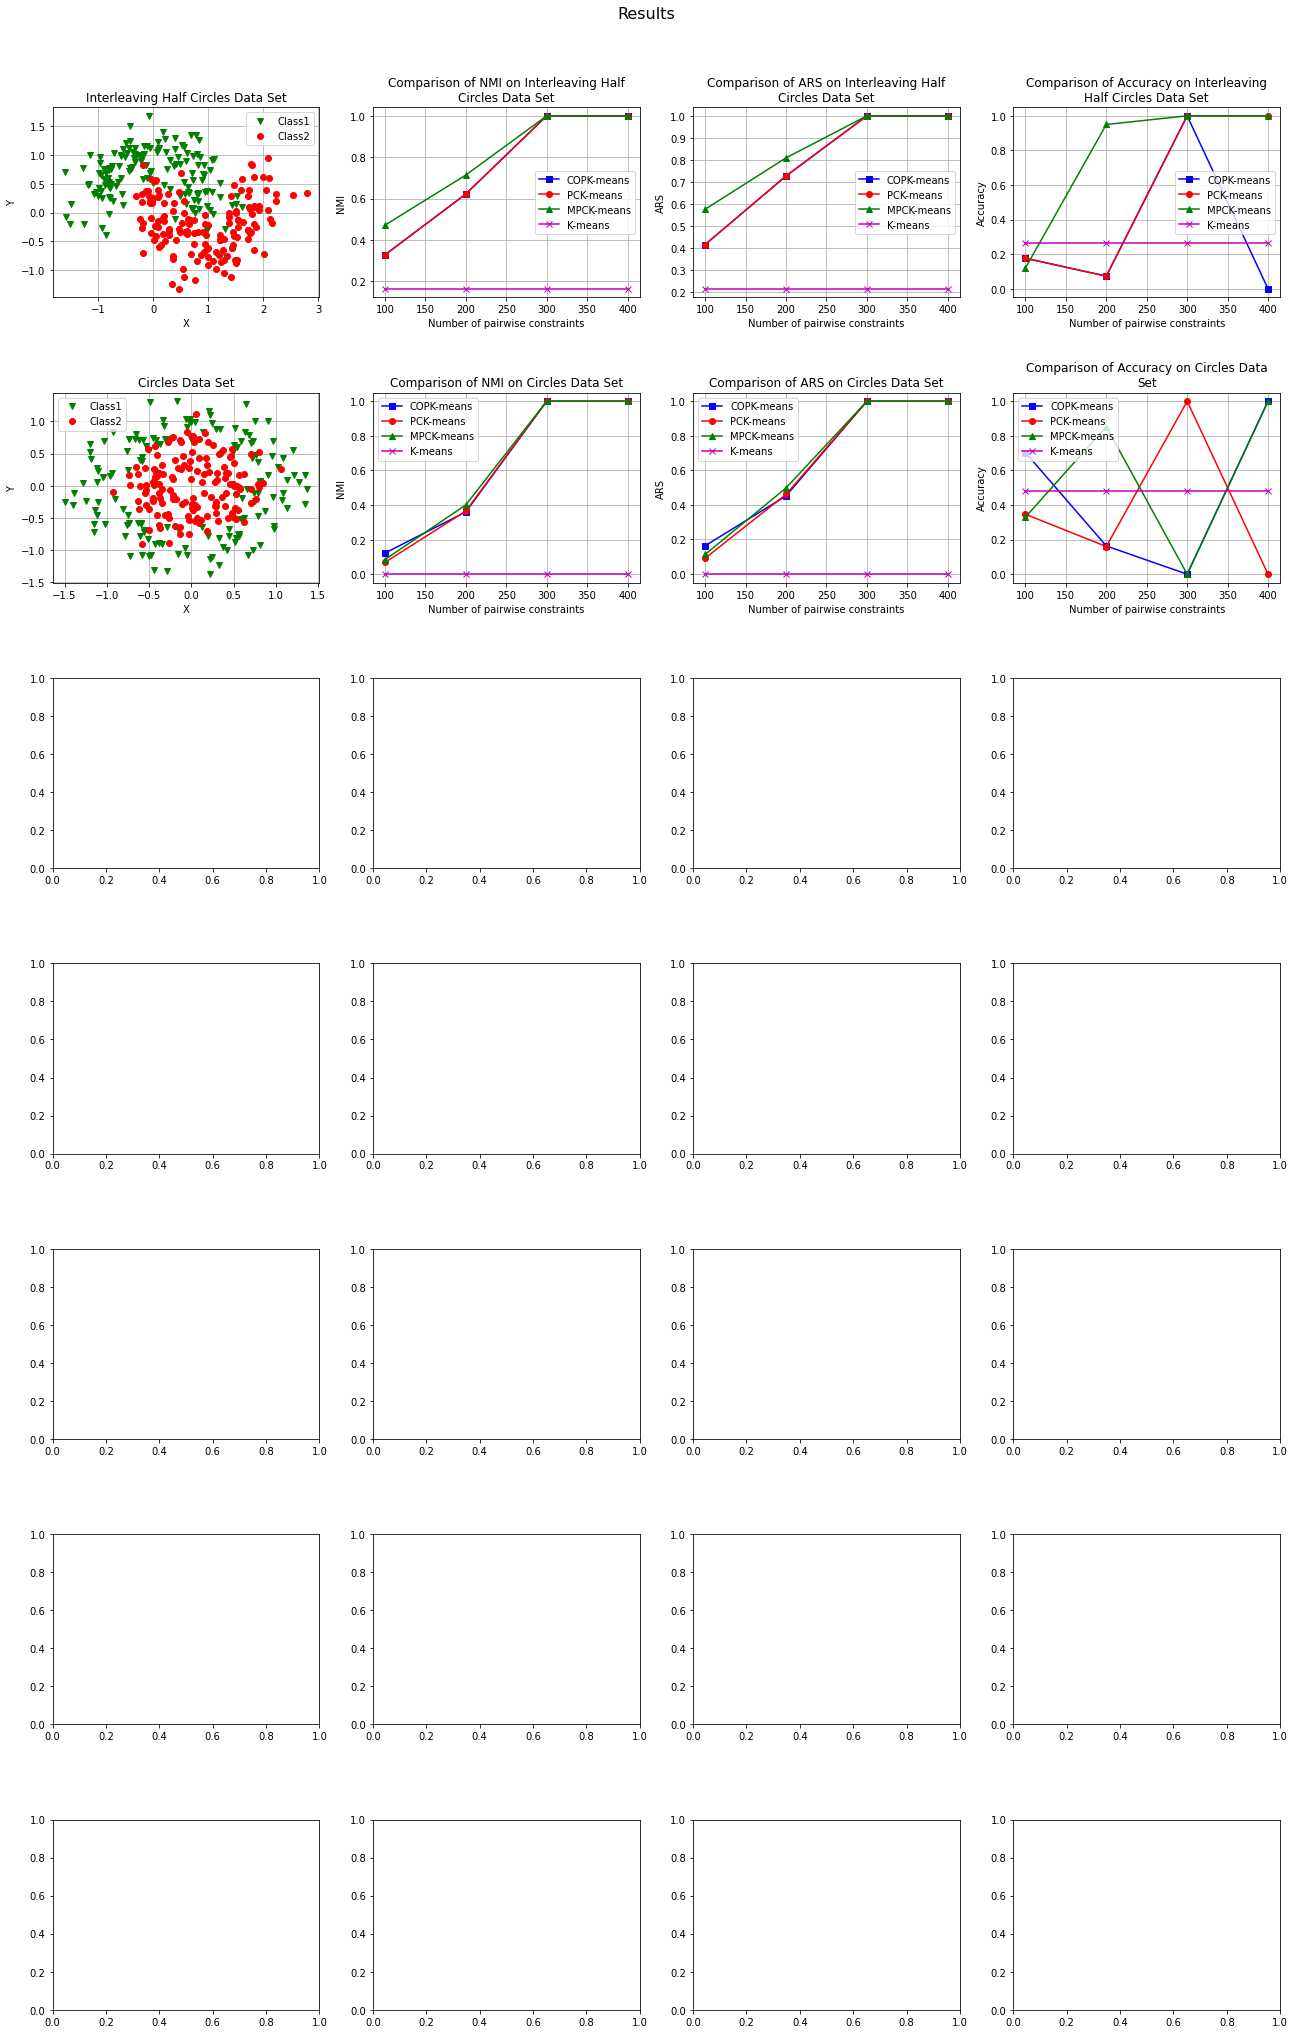

In [16]:
from sklearn.datasets import make_moons, make_circles, make_blobs, make_classification, make_gaussian_quantiles
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
from time import time
from joblib import Parallel, delayed

def anisotropicly_distributed_data(n_sample, n_feat):
    a_centers = [[1, 1], [-1, -1], [1, -1], [3,3]]
    X, y = make_blobs(n_samples=n_sample, n_features = n_feat, centers = a_centers, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)
    return aniso
    

def plot_scatterplot(Data, Labels, axs, title):
    markers = ['gv', 'ro', 'bx', 'm>']
    unq_lbls = np.unique(Labels)
    for lbl_cnt, label in enumerate(unq_lbls):
         axs.plot(Data[Labels == label,0],Data[Labels == label,1], markers[lbl_cnt])

    axs.set_title("\n".join(wrap(title, 40)))
    axs.grid('On')
    axs.legend(('Class1', 'Class2', 'Class3', 'Class4'))
    axs.set_xlabel('X')
    axs.set_ylabel('Y')

#if __name__ == "__main__":
    
figure, axs = plt.subplots(7, 4, figsize = (22,35))
plt.subplots_adjust(hspace = 0.5) 
figure.suptitle('Results', fontsize=16, y = 0.92)

centers = [[1, 1], [-1, -1], [1, -1], [3,3]]
n_sample = 300
datasets = [
    make_moons(n_samples = n_sample, noise=0.3, random_state=0),
    make_circles(n_samples = n_sample, noise=0.2, factor=0.5, random_state=1)

    #make_gaussian_quantiles(n_samples = n_sample, n_features=4, n_classes=4),
    #make_classification(n_samples = n_sample, n_features=8, n_redundant=0, n_informative=2, 
    #                    n_clusters_per_class=1, n_classes=4),  
    #make_blobs(n_samples=n_sample, n_features = 10, centers=centers, cluster_std=0.6),
    #make_blobs(n_samples=n_sample, n_features = 13, centers=centers, cluster_std=[1.0, 2.5, 0.5, 1.0], random_state=170),
    #anisotropicly_distributed_data(n_sample, 16),
]

name_ds = ['Interleaving Half Circles Data Set', 'Circles Data Set', 
           'Gaussian divided into four quantiles', 'Multi-class, two informative features, one cluster per class', 
           'Blobs with equal variance', 'Blobs with unequal variance', 'Blobs with anisotropicly distributed data']

plot_titles = ['Comparison of NMI on ', 'Comparison of ARS on ', 'Comparison of Accuracy on ']
Video_frames = []
k_folds = 2
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints   
'''
print('Data: ', datasets[0][0])
print('Labels: ', datasets[0][1])
params = [[datasets[0][0], datasets[0][1], Video_frames, arr_n_constraints, k_folds],
          [datasets[1][0], datasets[1][1], Video_frames, arr_n_constraints, k_folds]]
print('Params: ', params[0])
result = Parallel(n_jobs=3)(delayed(test_clustering_k_fold)(i) for i in params)

'''

for ds_cnt, ds in enumerate(datasets):
    Data, Labels = ds 
    un_lbl = np.unique(Labels)

    s_time_clus = time()
    plot_scatterplot(Data, Labels, axs[ds_cnt, 0], name_ds[ds_cnt])

    #params = [Data, Labels, Video_frames, arr_n_constraints, k_folds]
    all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, Video_frames, arr_n_constraints)

    plot_NMI(all_NMI, plot_titles[0] + name_ds[ds_cnt], axs[ds_cnt, 1])
    plot_ARS(all_ARS, plot_titles[1] + name_ds[ds_cnt], axs[ds_cnt, 2])
    plot_ACC(all_ACC, plot_titles[2] + name_ds[ds_cnt], axs[ds_cnt, 3])

    e_time_clus = time()
    print(name_ds[ds_cnt])
    print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")




In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import Counter

def load_label_files(Trn_lbl_file, Tst_lbl_file, class_labels_file, title):
    folder = 'Train_test_files'
    src = os.path.join(folder, Trn_lbl_file)
    df = pd.read_csv(src, header=None)
    df = df.iloc[:, 0].str.rstrip()
    Trn_cls_names = df.to_numpy()
    src = os.path.join(folder, Tst_lbl_file)
    df = pd.read_csv(src, header=None)
    df = df.iloc[:, 0].str.rstrip()
    Tst_cls_names = df.to_numpy()
    print(Trn_cls_names.shape)
    print(Tst_cls_names.shape)
    cls_names = np.vstack((Trn_cls_names.reshape((-1, 1)), Tst_cls_names.reshape((-1, 1))))

    src = os.path.join(folder, class_labels_file)
    cls_labels = pd.read_csv(src, header=None).to_numpy()
    labels = np.hstack((cls_labels.reshape((-1, 1)), cls_names[:,0].reshape(-1, 1)))
    new_labels = tuple(map(tuple, labels))
    unq_lbl = sorted(set(new_labels))
    unq_lbl = np.array(unq_lbl)
    print(title)
    print(unq_lbl)
    return unq_lbl[:, 1]

Trn_file = 'Train_BB_Pigs_49651_960_540_500f.csv'
Tst_file = 'Test_BB_Pigs_49651_960_540_500f.csv'
Lbl_file = 'Pigs_49651_960_540_500f_Labels.csv'
title = 'Pigs label names'
pigs_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Koi_5652_952_540.csv'
Tst_file = 'Test_BB_Koi_5652_952_540.csv'
Lbl_file = 'Koi_5652_952_540_Labels.csv'
title = 'Koi fish label names'
koi_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Pigeons_8234_1280_720.csv'
Tst_file = 'Test_BB_Pigeons_8234_1280_720.csv'
Lbl_file = 'Pigeons_8234_1280_720_Labels.csv'
title = 'Pigons on the curb - Label names'
pigeon_curb_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Pigeons_4927_960_540_600f.csv'
Tst_file = 'Test_BB_Pigeons_4927_960_540_600f.csv'
Lbl_file = 'Pigeons_4927_960_540_600f_Labels.csv'
title = 'Pigeons on the ground - Label names'
pigeon_ground_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Pigeons_29033_960_540_300f.csv'
Tst_file = 'Test_BB_Pigeons_29033_960_540_300f.csv'
Lbl_file = 'Pigeons_29033_960_540_300f_Labels.csv'
title = 'Pigeons on the square - Label names'
pigeon_square_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)

(2710,)
(3212,)
Pigs label names
[['0' 'Ash']
 ['1' 'Ben']
 ['2' 'Billy']
 ['3' 'Bobby']
 ['4' 'Chelsea']
 ['5' 'Honey']
 ['6' 'Isaac']
 ['7' 'Jack']
 ['8' 'Jean']
 ['9' 'Kat']
 ['10' 'Keagan']
 ['11' 'Kim']
 ['12' 'Lola']
 ['13' 'Martin']
 ['14' 'Nancy']
 ['15' 'Peter']
 ['16' 'Phil']
 ['17' 'Sharon']
 ['18' 'Shirley']
 ['19' 'Stacey']
 ['20' 'Tiff']
 ['21' 'Whitney']]
(916,)
(719,)
Koi fish label names
[['0' 'Catherine']
 ['1' 'Dwayne']
 ['2' 'Florence']
 ['3' 'Humphrey']
 ['4' 'JP']
 ['5' 'Jack']
 ['6' 'Ruby']
 ['7' 'Selwyn']
 ['8' 'Siobhan']]
(2268,)
(2291,)
Pigons on the curb - Label names
[['0' 'Ederson']
 ['1' 'Foden']
 ['2' 'Grealish']
 ['3' 'Gundogan']
 ['4' 'Kevin']
 ['5' 'Laporte']
 ['6' 'Mahrez']
 ['7' 'Rodri']
 ['8' 'Silva']
 ['9' 'Sterling']
 ['10' 'Stones']
 ['11' 'Torres']
 ['12' 'Walker']]
(1574,)
(1303,)
Pigeons on the ground - Label names
[['0' 'Alexander']
 ['1' 'Bertie']
 ['2' 'Edward']
 ['3' 'Friedrich']
 ['4' 'George']
 ['5' 'Haakon']
 ['6' 'Harald']
 ['7' 'Henry

In [4]:
class MaximumQueriesExceeded(Exception):
    pass

class VideoOracle:
    def __init__(self, labels, frames, max_queries_cnt=20):
        self.labels = labels
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.frames = frames

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            
            return self.frames[i] == self.frames[j]
        else:
            raise MaximumQueriesExceeded

# Get constraints
def get_constraints(Data, Labels, n_constraints):
    ML = []
    CL = []
    ml_cnt = 0
    cl_cnt = 0
    n_labels = len(Labels)
    #print('n labels: ',  n_labels)
    i = 0
    j = 0
    while((i < n_labels) and ((len(ML) + len(CL)) < n_constraints)):
        while((j < n_labels) and ((len(ML) + len(CL)) < n_constraints)):
            if (i!=j):
                if (Labels[i] == Labels[j]):
                    ML.append((i,j))
                else:             
                    CL.append((i,j))
                
            j = j + 1
        j = 0
        i = i + 1
            
    #print('ml cnt: ', len(ML))
    #print('cl cnt: ', len(CL))
    #print('ML =', ML)
    #print('CL =', CL)
    return ML, CL 

In [221]:
from sklearn import datasets, metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
from sklearn.metrics.cluster import normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Load data sets and keep the 4 feature representations separate
def load_dataset(pathFeat1, pathFeat2, pathFeat3, pathFeat4, pathLabels, pathFrames):
    #Load dataset
    print('\nData and features')
    Data_RGB = pd.read_csv(pathFeat1, header=None).to_numpy()
    n_obj, feat = Data_RGB.shape
    print(' RGB: ', n_obj, ' feat: ', feat )
    Data_HOG = pd.read_csv(pathFeat2, header=None).to_numpy()
    n_obj, feat = Data_HOG.shape
    print(' HOG: ', n_obj, ' feat: ', feat )
    Data_H10 = pd.read_csv(pathFeat3, header=None).to_numpy()
    n_obj, feat = Data_H10.shape
    print(' H10: ', n_obj, ' feat: ', feat )
    Data_LBP = pd.read_csv(pathFeat4, header=None).to_numpy()
    n_obj, feat = Data_LBP.shape
    print(' LBP: ', n_obj, ' feat: ', feat )
    
    #Load labels
    Df_labels = pd.read_csv(pathLabels, header=None)
    Labels = Df_labels.to_numpy()
    #Load frames
    Df_frames = pd.read_csv(pathFrames, header=None)
    Frames = Df_frames.to_numpy() 
    return [Data_RGB, Data_HOG, Data_H10, Data_LBP], Labels, Frames


print('\nLoad Df_pigs_data')
Pigs_data, Pigs_labels, Pigs_frames = load_dataset('AnimalDataBase/Pigs_49651_960_540_500f_DataRGB.csv', 
                                      'AnimalDataBase/Pigs_49651_960_540_500f_DataHOG.csv',
                                      'AnimalDataBase/Pigs_49651_960_540_500f_DataH10.csv', 
                                      'AnimalDataBase/Pigs_49651_960_540_500f_DataLBP.csv',
                                      'AnimalDataBase/Pigs_49651_960_540_500f_Labels.csv',
                                      'AnimalDataBase/Pigs_49651_960_540_500f_FrameNumbers.csv')
print('Frames: ', Pigs_frames)
print('\nLoad Df_koi_data')
Koi_data, Koi_labels, Koi_frames = load_dataset('AnimalDataBase/Koi_5652_952_540_DataRGB.csv', 
                                    'AnimalDataBase/Koi_5652_952_540_DataHOG.csv',
                                    'AnimalDataBase/Koi_5652_952_540_DataH10.csv', 
                                    'AnimalDataBase/Koi_5652_952_540_DataLBP.csv',
                                    'AnimalDataBase/Koi_5652_952_540_Labels.csv',
                                    'AnimalDataBase/Koi_5652_952_540_FrameNumbers.csv')


print('\nLoad Df_pigeons_curb_data')
Pigeons_curb_data, Pigeons_curb_labels, Pigeons_curb_frames = load_dataset('AnimalDataBase/Pigeons_8234_1280_720_DataRGB.csv', 
                                                      'AnimalDataBase/Pigeons_8234_1280_720_DataHOG.csv',
                                                      'AnimalDataBase/Pigeons_8234_1280_720_DataH10.csv', 
                                                      'AnimalDataBase/Pigeons_8234_1280_720_DataLBP.csv',
                                                      'AnimalDataBase/Pigeons_8234_1280_720_Labels.csv',
                                                      'AnimalDataBase/Pigeons_8234_1280_720_FrameNumbers.csv')


print('\nLoad Df_pigeons_ground_data')
Pigeons_ground_data, Pigeons_ground_labels, Pigeons_ground_frames = load_dataset('AnimalDataBase/Pigeons_4927_960_540_600f_DataRGB.csv', 
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_DataHOG.csv',
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_DataH10.csv', 
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_DataLBP.csv',
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_Labels.csv',
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_FrameNumbers.csv')


print('\nLoad Df_pigeons_square_data')
Pigeons_square_data, Pigeons_square_labels, Pigeons_ground_frames = load_dataset('AnimalDataBase/Pigeons_29033_960_540_300f_DataRGB.csv', 
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_DataHOG.csv',
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_DataH10.csv', 
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_DataLBP.csv',
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_Labels.csv',
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_FrameNumbers.csv')


#pairwise_clustering(Data, Labels, titles, [axs[0,1], axs[2,1]])

#Setting up sub-plots
figure, axs = plt.subplots(6, 4, figsize = (25,35))
plt.subplots_adjust(hspace = 0.5) 
plt.suptitle('Results', fontsize=16, y=0.92)

n_sample = 178 #Total number of instances
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
feat_plot = [0,3]
lbl_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'] #Only the first 5 RGB features (54)
cls_names = pigs_lbl_names
titles = ['Comparison of NMI on Pigs Data Set', 'Comparison of ARS on Pigs Data Set', 
          'Comparison of Accuracy on Pigs Data Set']

symb_marker = '*'
plot_scatterplot(Pigs_data, Pigs_labels, axs[1,0], 'Scatterplot of Pigs Data Set', 
                 feat_plot, lbl_names, cls_names, symb_marker)

all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, arr_n_constraints)
plot_NMI(all_NMI, titles[0], axs[1,1])
plot_ARS(all_ARS, titles[1], axs[1,2])
plot_ACC(all_ACC, titles[2], axs[1,3])




Load Df_pigs_data

Data and features
 RGB:  5922  feat:  54
 HOG:  5922  feat:  441
 H10:  5922  feat:  10
 LBP:  5922  feat:  50
Frames:  [[  1]
 [  1]
 [  1]
 ...
 [500]
 [500]
 [500]]

Load Df_koi_data

Data and features
 RGB:  1635  feat:  54
 HOG:  1635  feat:  441
 H10:  1635  feat:  10
 LBP:  1635  feat:  50

Load Df_pigeons_curb_data

Data and features
 RGB:  4559  feat:  54
 HOG:  4559  feat:  441
 H10:  4559  feat:  10
 LBP:  4559  feat:  50

Load Df_pigeons_ground_data

Data and features
 RGB:  2877  feat:  54
 HOG:  2877  feat:  441
 H10:  2877  feat:  10
 LBP:  2877  feat:  50

Load Df_pigeons_square_data

Data and features
 RGB:  4389  feat:  54
 HOG:  4389  feat:  441
 H10:  4389  feat:  10
 LBP:  4389  feat:  50
